<a href="https://colab.research.google.com/github/ParthUpah/RISEN_CS367_LAB_CODES/blob/main/lab8_problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration 1: Policy Evaluation...
Iteration 1: Policy Improvement...
Iteration 2: Policy Evaluation...
Iteration 2: Policy Improvement...


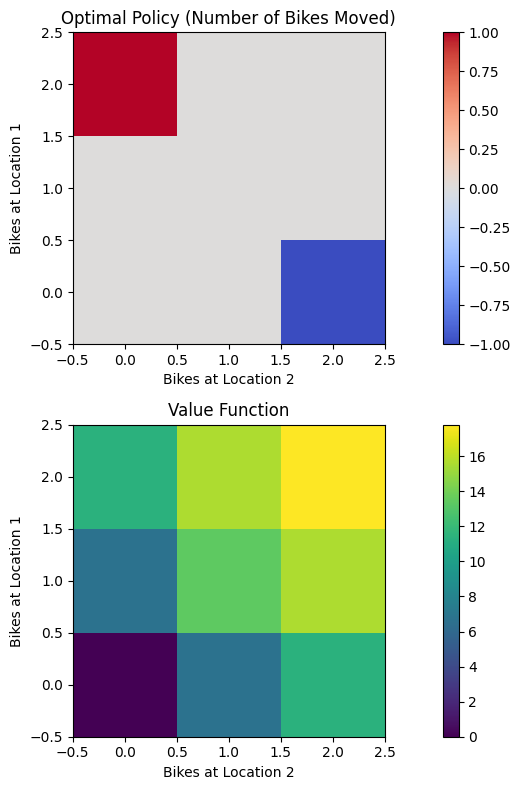

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Parameters for minimal input
Lamda = [1, 1]  # Expected rental requests (location 1 and 2)
lamda = [1, 1]  # Expected returns (location 1 and 2)
r = 10          # Rental reward
t = 2           # Transfer cost per bike
parking_cost = 4  # Additional parking cost for exceeding 10 bikes
free_transfer = 1  # Free bike transfer from location 1 to location 2
gam = 0.5        # Discount factor (lower for faster convergence)
max_bikes = 2    # Maximum bikes at each location
max_transfer = 1  # Maximum bikes transferred overnight
theta = 1         # Convergence threshold (higher for faster convergence)


# Initialize policy and value function
policy = np.zeros((max_bikes + 1, max_bikes + 1), dtype=int)
V = np.zeros((max_bikes + 1, max_bikes + 1))

# Poisson probabilities precomputed for requests and returns
poisson_cache = {}
def poisson_prob(n, lam):
    if (n, lam) not in poisson_cache:
        poisson_cache[(n, lam)] = poisson.pmf(n, lam)
    return poisson_cache[(n, lam)]

def expected_value(s1, s2, a, V, Lamda, lamda, r, t, gam, max_bikes):
    """
    Calculate the expected value for a given state (s1, s2) and action (a).
    """
    # Adjust state based on action
    s1_ = s1 - a
    s2_ = s2 + a
    if s1_ < 0 or s2_ < 0 or s1_ > max_bikes or s2_ > max_bikes:
        return -np.inf  # Invalid state-action pair

    # Immediate cost for moving bikes
    reward = -abs(a) * t
    Vs_ = 0

    # Iterate over all possible rental requests and returns
    for n1 in range(0, max_bikes + 1):
        for n2 in range(0, max_bikes + 1):
            # Remaining bikes after rentals
            s1__ = max(s1_ - n1, 0)
            s2__ = max(s2_ - n2, 0)

            for n3 in range(0, max_bikes + 1):
                for n4 in range(0, max_bikes + 1):
                    # Final bikes after returns
                    s1___ = min(s1__ + n3, max_bikes)
                    s2___ = min(s2__ + n4, max_bikes)

                    prob = (
                        poisson_prob(n1, Lamda[0]) *
                        poisson_prob(n2, Lamda[1]) *
                        poisson_prob(n3, lamda[0]) *
                        poisson_prob(n4, lamda[1])
                    )
                    reward += prob * (min(n1, s1_) + min(n2, s2_)) * r
                    Vs_ += prob * V[s1_, s2_]
    return reward + gam * Vs_

# Policy iteration loop
policy_stable = False
iteration = 0

while not policy_stable:
    iteration += 1
    print(f"Iteration {iteration}: Policy Evaluation...")

    # Policy Evaluation
    delta = float('inf')
    while delta > theta:
        delta = 0
        for i in range(max_bikes + 1):
            for j in range(max_bikes + 1):
                s1, s2 = i, j
                v = V[s1, s2]
                a = policy[s1, s2]
                V[s1, s2] = expected_value(s1, s2, a, V, Lamda, lamda, r, t, gam, max_bikes)
                delta = max(delta, abs(v - V[s1, s2]))

    print(f"Iteration {iteration}: Policy Improvement...")
    policy_stable = True
    for i in range(max_bikes + 1):
        for j in range(max_bikes + 1):
            s1, s2 = i, j
            old_action = policy[s1, s2]
            actions = range(
                -min(min(s2, max_transfer), max_bikes - s1),
                 min(min(s1, max_transfer), max_bikes - s2) + 1
            )
            action_values = [
                expected_value(s1, s2, a, V, Lamda, lamda, r, t, gam, max_bikes)
                for a in actions
            ]
            policy[s1, s2] = actions[np.argmax(action_values)]
            if old_action != policy[s1, s2]:
                policy_stable = False

# Visualization
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Plot the optimal policy
c = ax[0].imshow(policy, cmap='coolwarm', origin='lower')
ax[0].set_title("Optimal Policy (Number of Bikes Moved)")
ax[0].set_xlabel("Bikes at Location 2")
ax[0].set_ylabel("Bikes at Location 1")
fig.colorbar(c, ax=ax[0])

# Plot the value function
c = ax[1].imshow(V, cmap='viridis', origin='lower')
ax[1].set_title("Value Function")
ax[1].set_xlabel("Bikes at Location 2")
ax[1].set_ylabel("Bikes at Location 1")
fig.colorbar(c, ax=ax[1])

plt.tight_layout()
plt.show()